## Install the xesmf packages

#User Kernal to install xesmf packages 

##Create a Separate env for the xesmf packages (Heavy Packages) or you can install this package into the geospatial environment. 
#Use conda to configure these packages only 
#Code write date 18-01-24 Anurag Sahu

$ conda create -n xesmf_env

#Active the created environment 
$ conda activate xesmf_env

#Start the installation process
$ conda install -c conda-forge xesmf

#To support all features in xESMF
$ conda install -c conda-forge dask netCDF4

#optional dependencies for executing all notebook examples
$ conda install -c conda-forge matplotlib cartopy jupyterlab

#Alternative to install these packages mannualy
$ conda install -c conda-forge esmpy xarray numpy shapely cf_xarray sparse numba

##All test must need to pass
 pip install pytest
 pytest -v --pyargs xesmf  # should all pass



In [24]:
import os
import pandas as pd
import netCDF4 as nc
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import dask
from mpl_toolkits.basemap import Basemap


In [2]:
globe = ccrs.Globe(semimajor_axis=6371229, semiminor_axis=6371229)

tm_crs = ccrs.TransverseMercator(central_longitude=70.0, central_latitude=16.0, false_easting=-25000.0, false_northing=-25000.0, scale_factor=1.0, globe=globe)


## Pre Processing

In [3]:

ds_in = xr.open_dataset("C:/Users/Anurag Sahu/Desktop/CEEW/Cordex Data/CORDEX_Hist_tasmax_CCCma_1976_2005.nc")


In [4]:
ds_in

<xarray.Dataset>
Dimensions:    (time: 10950, bnds: 2, y: 167, x: 253)
Coordinates:
    lat        (y, x) float64 ...
    lon        (y, x) float64 ...
  * x          (x) float64 -6.3e+06 -6.25e+06 -6.2e+06 ... 6.25e+06 6.3e+06
  * y          (y) float64 -4.15e+06 -4.1e+06 -4.05e+06 ... 4.1e+06 4.15e+06
  * time       (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    crs        (time) |S1 ...
    tasmax     (time, y, x) float32 ...

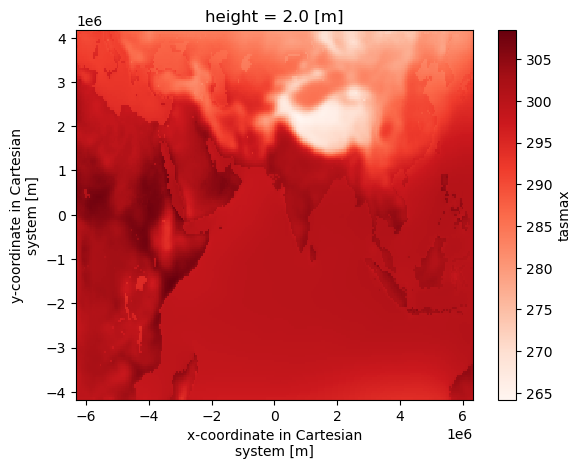

In [55]:
tasmax_mean=ds_in['tasmax'].mean('time')

tasmax_mean.plot(cmap='Reds')

#plt.savefig("C:/Users/Anurag Sahu/Desktop/CEEW/BeforeF.png",dpi=1000)

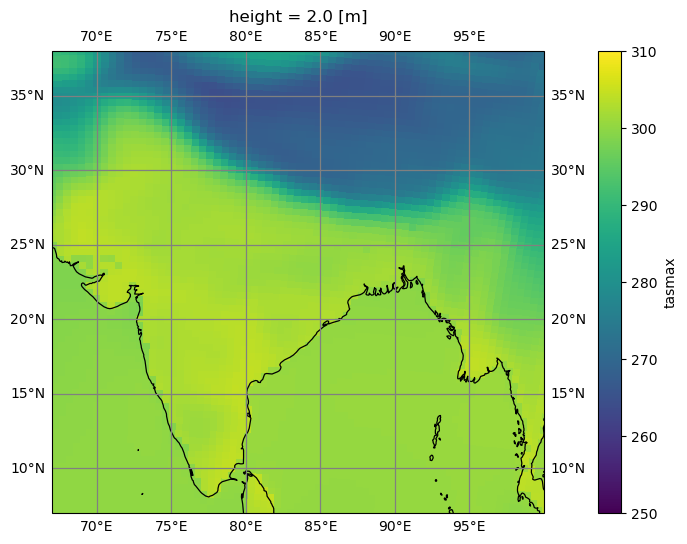

In [59]:
plt.figure(figsize=(14, 6))

ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.set_global()
ax1.set_extent([67, 100, 7, 38], crs = ccrs.PlateCarree()) 
ax1.gridlines(draw_labels=True, linewidth=0.9, color='gray')
ax1.coastlines(resolution='50m', linewidth=0.9, color='black')
ax1.set_title('Trial', fontsize=10, fontweight='bold')
ds_in['tasmax'].mean('time').plot.pcolormesh(
    ax=ax1, x="lon", y="lat",vmin = 250, vmax = 310)


#ds_in["tasmax"].isel(time = 0)

#plt.savefig("C:/Users/Anurag Sahu/Desktop/CEEW/Before.png",dpi=1000)

In [7]:
dr = ds_in["tasmax"]

In [17]:
#ds_in = ds_in.isel(time = slice(0, 200))
#ds_in

<xarray.Dataset>
Dimensions:    (time: 200, bnds: 2, y: 167, x: 253)
Coordinates:
    lat        (y, x) float64 -25.23 -25.13 -25.04 -24.95 ... 42.65 42.54 42.42
    lon        (y, x) float64 20.79 21.19 21.58 21.97 ... 137.1 137.6 138.1
  * x          (x) float64 -6.3e+06 -6.25e+06 -6.2e+06 ... 6.25e+06 6.3e+06
  * y          (y) float64 -4.15e+06 -4.1e+06 -4.05e+06 ... 4.1e+06 4.15e+06
  * time       (time) object 1976-01-01 12:00:00 ... 1976-07-19 12:00:00
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    crs        (time) |S1 ...
    tasmax     (time, y, x) float32 298.7 298.7 298.9 ... 291.2 291.6 292.6

## Must need xesmf and ESMPY Packages

#xe.util.grid_2d is usedto convert Curvilinear grid(3d) to rectilinear grid(2d) funcyion called from xesmf packages 
#Use Shift + Teb to explore the function
#careful its xe not xr

In [25]:
ds_out = xe.util.grid_2d(66.375, 100.125, 0.25, 6.375, 38.625, 0.25) 
ds_out

<xarray.Dataset>
Dimensions:  (y: 129, x: 135, y_b: 130, x_b: 136)
Coordinates:
    lon      (y, x) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
    lat      (y, x) float64 6.5 6.5 6.5 6.5 6.5 6.5 ... 38.5 38.5 38.5 38.5 38.5
    lon_b    (y_b, x_b) float64 66.38 66.62 66.88 67.12 ... 99.62 99.88 100.1
    lat_b    (y_b, x_b) float64 6.375 6.375 6.375 6.375 ... 38.62 38.62 38.62
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [26]:
regridder = xe.Regridder(ds_in, ds_out, "bilinear")

In [27]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_167x253_129x135.nc 
Reuse pre-computed weights? False 
Input grid shape:           (167, 253) 
Output grid shape:          (129, 135) 
Periodic in longitude?      False

## regridder_weights.nc must be saved in your desk location 

In [30]:
regridder.to_netcdf('regridder_weights.nc')

'regridder_weights.nc'

In [11]:
ds_out = regridder(dr, keep_attrs=True)
ds_out

<xarray.DataArray 'tasmax' (time: 10950, y: 129, x: 135)>
array([[[299.23386, 299.24118, 299.2496 , ..., 298.32446, 298.3361 ,
         298.31488],
        [299.23474, 299.23703, 299.24094, ..., 298.13467, 298.13684,
         298.1407 ],
        [299.2458 , 299.24136, 299.23755, ..., 298.08215, 298.07983,
         298.09088],
        ...,
        [274.67566, 274.17157, 273.74567, ..., 261.06567, 261.78464,
         262.42212],
        [274.66147, 273.9674 , 273.4058 , ..., 261.6446 , 262.408  ,
         262.83212],
        [274.47134, 273.66153, 272.9813 , ..., 262.4532 , 263.3745 ,
         264.1946 ]],

       [[299.23486, 299.20792, 299.19525, ..., 299.10782, 299.13535,
         299.0762 ],
        [299.17422, 299.15134, 299.144  , ..., 298.8598 , 298.9011 ,
         298.90857],
        [299.11063, 299.0925 , 299.0918 , ..., 298.85144, 299.02777,
         299.34866],
...
        [274.49127, 274.03458, 273.6972 , ..., 256.18488, 257.02112,
         257.2716 ],
        [274.12567, 273.64212, 273.32385, ..., 257.07056, 258.01633,
         257.6204 ],
        [274.43628, 273.63773, 273.22546, ..., 257.2015 , 257.95776,
         257.86334]],

       [[300.38608, 300.34406, 300.3074 , ..., 301.40277, 301.40714,
         301.45416],
        [300.39578, 300.36218, 300.33325, ..., 301.55972, 301.63538,
         301.9803 ],
        [300.4039 , 300.37967, 300.3595 , ..., 301.85184, 302.16153,
         303.2365 ],
        ...,
        [274.82184, 274.12823, 273.43533, ..., 253.12198, 253.82452,
         254.25653],
        [273.5849 , 273.08817, 272.6171 , ..., 253.86107, 254.48108,
         254.34445],
        [273.70877, 272.93533, 272.39798, ..., 254.2446 , 254.51152,
         254.19266]]], dtype=float32)
Coordinates:
  * time     (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height   float64 2.0
    lon      (y, x) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
    lat      (y, x) float64 6.5 6.5 6.5 6.5 6.5 6.5 ... 38.5 38.5 38.5 38.5 38.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [13]:
ds_out.to_netcdf('regridder_weights_F.nc')

In [14]:
###Cheack below regridder code for the .nc file
F1 = xr.open_dataset('regridder_weights_F.nc')
F1
#F1["tasmax"].values

<xarray.Dataset>
Dimensions:  (time: 10950, y: 129, x: 135)
Coordinates:
  * time     (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height   float64 ...
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    tasmax   (time, y, x) float32 ...

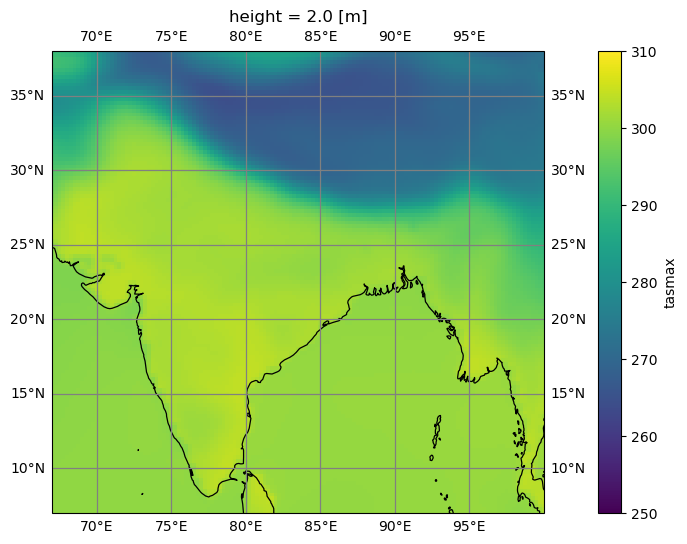

In [15]:

plt.figure(figsize=(14, 6))

ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.set_global()
ax2.set_extent([67, 100, 7, 38], crs = ccrs.PlateCarree()) 
ax2.gridlines(draw_labels=True, linewidth=0.9, color='gray')
ax2.coastlines(resolution='50m', linewidth=0.9, color='black')
ax2.set_title('Trial', fontsize=10, fontweight='bold')
F1['tasmax'].mean('time').plot.pcolormesh(
    ax=ax2,  x="lon", y="lat", vmin = 250, vmax = 310)

#transform=tm_crs,
#plt.savefig("C:/Users/Anurag Sahu/Desktop/CEEW/After.png",dpi=1000)

In [16]:
print(F1["tasmax"].dims)
print(F1["tasmax"].coords)


('time', 'y', 'x')
Coordinates:
  * time     (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height   float64 2.0
    lon      (y, x) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
    lat      (y, x) float64 6.5 6.5 6.5 6.5 6.5 6.5 ... 38.5 38.5 38.5 38.5 38.5


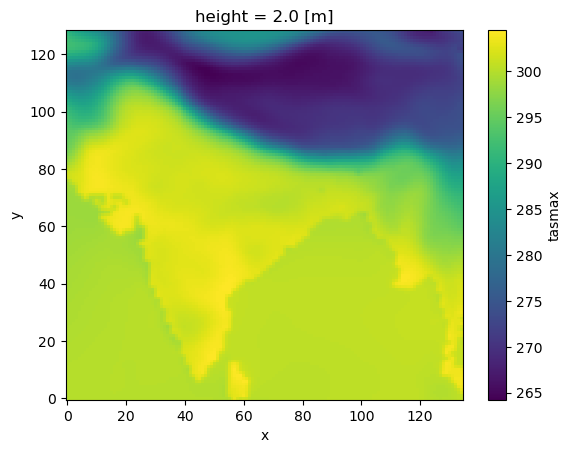

In [17]:
F1['tasmax'].mean('time').plot()

In [25]:
#dsat["lat"].values, dsat["lon"].values

In [19]:
#ds_out

## Post Processing

In [31]:
def regrid_to_imdp25(ds_in):
    ds_out = xe.util.grid_2d(66.375, 100.125, 0.25, 6.375, 38.625, 0.25)
    regridder = xe.Regridder(ds_in, ds_out, "bilinear", weights="regridder_weights.nc")
    ds_out = regridder(ds_in.compute())
    ds_out.attrs.update(ds_in.attrs)
   # ds_out.attrs['old_crs'] = ds_out.attrs['crs'] 
    
    # put the correct resolution here for reference
    ds_out.attrs['crs'] = 'IMD 0.25 degree x 0.25 degree'
    ds_out.attrs['creation_date'] = pd.Timestamp.utcnow().strftime("%Y-%m-%d %H:%M:%SZ")
    ds_out = ds_out.assign_coords({'y': np.arange(6.5,38.75,0.25, dtype='float64'), 'x': np.arange(66.5,100.25,0.25, dtype='float64')}) 
    ds_out = ds_out.drop_vars(['lat', 'lon'])
    ds_out = ds_out.rename({ 'x': 'lon', 'y': 'lat' }) 
    ds_out = ds_out.chunk({"time": 365, "lat": 33, "lon": 34}) 
    return ds_out



In [32]:

ds_out_Final = regrid_to_imdp25(ds_in)


In [33]:
ds_out_Final

<xarray.Dataset>
Dimensions:  (time: 10950, lat: 129, lon: 135)
Coordinates:
  * time     (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height   float64 2.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear
    crs:            IMD 0.25 degree x 0.25 degree
    creation_date:  2024-01-18 19:03:45Z

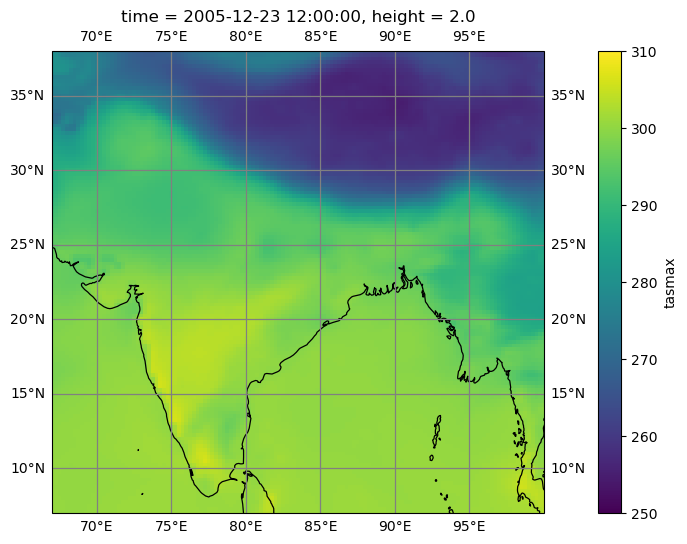

In [43]:

plt.figure(figsize=(14, 6))

ax3 = plt.axes(projection=ccrs.PlateCarree())
ax3.set_global()
ax3.set_extent([67, 100, 7, 38], crs = ccrs.PlateCarree()) 
ax3.gridlines(draw_labels=True, linewidth=0.9, color='gray')
ax3.coastlines(resolution='50m', linewidth=0.9, color='black')
ax3.set_title('Trial', fontsize=10, fontweight='bold')
ds_out_Final["tasmax"].isel(time = 10941).plot.pcolormesh(
    ax=ax3,  x="lon", y="lat", vmin = 250, vmax = 310)

#ds_out_Final["tasmax"].mean('time')
#transform=tm_crs,
#plt.savefig("C:/Users/Anurag Sahu/Desktop/CEEW/Final.png",dpi=1000)

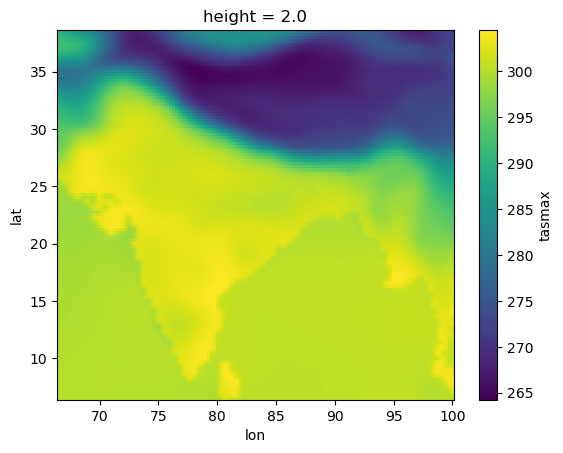

In [44]:
ds_out_Final["tasmax"].mean('time').plot()

In [34]:

# Compare means

min_lat = 18
max_lat = 19

min_lon = 79
max_lon = 80

# mean from output grid
ds_out_Final["tasmax"].mean('time').sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat)).mean().values

# mean from input grid
xr.where(
    (ds_in.lat >= min_lat) & (ds_in.lat <= max_lat) & (ds_in.lon >= min_lon) & (ds_in.lon <= max_lon),
    ds_in["tasmax"],
    np.nan
).isel(time=0).mean().values


array(301.2534, dtype=float32)

In [161]:
ds_out_Final.to_netcdf('India_tasmax_F.nc')

In [35]:
F2 = xr.open_dataset('India_tasmax_F.nc')
F2

<xarray.Dataset>
Dimensions:  (time: 10950, lat: 129, lon: 135)
Coordinates:
  * time     (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height   float64 ...
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    tasmax   (time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear
    creation_date:  2024-01-18 17:51:09Z

In [36]:
TMPMAX = F2["tasmax"]
TMPMAX

<xarray.DataArray 'tasmax' (time: 10950, lat: 129, lon: 135)>
[190694250 values with dtype=float32]
Coordinates:
  * time     (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height   float64 ...
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0

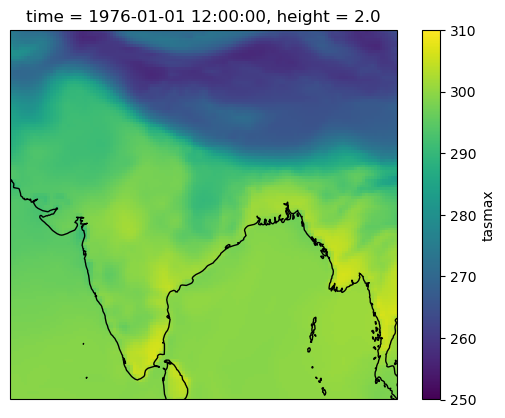

In [37]:
ax = plt.axes(projection=ccrs.PlateCarree())
TMPMAX.isel(time=0).plot.pcolormesh(ax=ax, vmin=250, vmax=310)
ax.coastlines()

In [38]:
F2["lat"].values, F2["lon"].values

(array([ 6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,
         8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75,
        11.  , 11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  ,
        13.25, 13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25,
        15.5 , 15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 ,
        17.75, 18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75,
        20.  , 20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  ,
        22.25, 22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25,
        24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 ,
        26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75,
        29.  , 29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75, 31.  ,
        31.25, 31.5 , 31.75, 32.  , 32.25, 32.5 , 32.75, 33.  , 33.25,
        33.5 , 33.75, 34.  , 34.25, 34.5 , 34.75, 35.  , 35.25, 35.5 ,
        35.75, 36.  , 36.25, 36.5 , 36.75, 37.  , 37.25, 37.5 , 37.75,
      

In [39]:
grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(6.5, 38.5, 0.12), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(66.5, 100.0, 0.12), {"units": "degrees_east"}),
    }
)
grid

<xarray.Dataset>
Dimensions:  (lat: 267, lon: 280)
Coordinates:
  * lat      (lat) float64 6.5 6.62 6.74 6.86 6.98 ... 38.06 38.18 38.3 38.42
  * lon      (lon) float64 66.5 66.62 66.74 66.86 ... 99.62 99.74 99.86 99.98
Data variables:
    *empty*

## 12 KM rectilinear grid resolution IMDAA data matching 

In [41]:
regridder = xe.Regridder(F2, grid, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_129x135_267x280.nc 
Reuse pre-computed weights? False 
Input grid shape:           (129, 135) 
Output grid shape:          (267, 280) 
Periodic in longitude?      False

In [42]:
dr_out = regridder(TMPMAX, keep_attrs=True)
dr_out

<xarray.DataArray 'tasmax' (time: 10950, lat: 267, lon: 280)>
array([[[299.23386,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [299.23428, 299.23663, 299.23898, ..., 298.24017, 298.23642,
         298.232  ],
        [299.2347 , 299.2359 , 299.2371 , ..., 298.1447 , 298.1461 ,
         298.14743],
        ...,
        [274.66544, 274.35785, 274.0502 , ..., 262.2034 , 262.44623,
         262.6786 ],
        [274.62344, 274.27924, 273.93494, ..., 262.56946, 262.82245,
         263.06424],
        [274.5322 , 274.16132, 273.79034, ..., 263.03036, 263.37003,
         263.70303]],

       [[299.23486,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [299.20575, 299.19376, 299.18176, ..., 299.02155, 299.01096,
         298.99792],
        [299.17664, 299.1656 , 299.1545 , ..., 298.90884, 298.9126 ,
         298.9149 ],
...
        [274.22803, 273.99963, 273.77106, ..., 257.70102, 257.6429 ,
         257.5399 ],
        [274.1878 , 273.9254 , 273.66312, ..., 257.9683 , 257.8569 ,
         257.6958 ],
        [274.33688, 274.00192, 273.66705, ..., 257.94382, 257.8925 ,
         257.80084]],

       [[300.38608,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [300.39075, 300.3725 , 300.35428, ..., 301.51514, 301.60028,
         301.6915 ],
        [300.3954 , 300.3791 , 300.36282, ..., 301.62332, 301.77274,
         301.9326 ],
        ...,
        [273.93124, 273.66666, 273.4015 , ..., 254.27148, 254.30708,
         254.31802],
        [273.60968, 273.34467, 273.07968, ..., 254.4652 , 254.41103,
         254.32796],
        [273.66913, 273.3404 , 273.01163, ..., 254.48659, 254.38715,
         254.26208]]], dtype=float32)
Coordinates:
  * time     (time) object 1976-01-01 12:00:00 ... 2005-12-31 12:00:00
    height   float64 2.0
  * lat      (lat) float64 6.5 6.62 6.74 6.86 6.98 ... 38.06 38.18 38.3 38.42
  * lon      (lon) float64 66.5 66.62 66.74 66.86 ... 99.62 99.74 99.86 99.98
Attributes:
    regrid_method:  bilinear

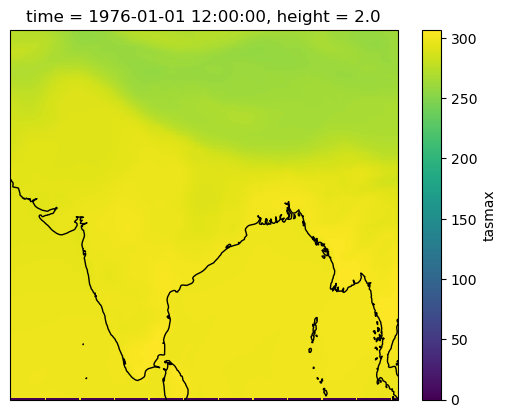

In [49]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax)
ax.coastlines()

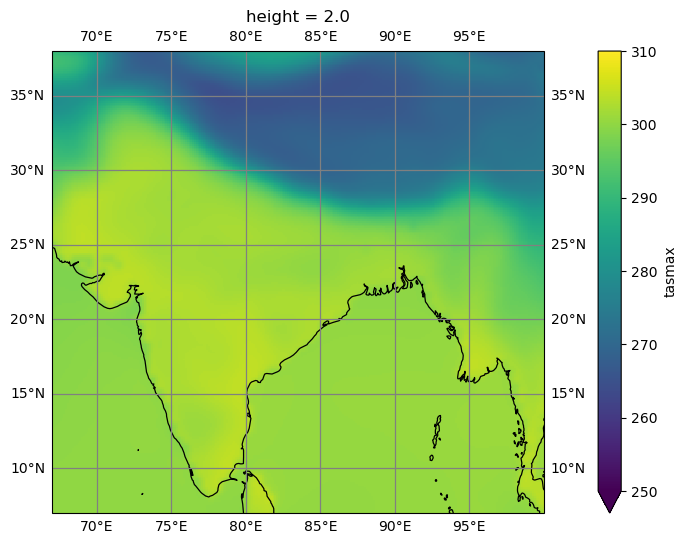

In [52]:

plt.figure(figsize=(14, 6))

ax4 = plt.axes(projection=ccrs.PlateCarree())
ax4.set_global()
ax4.set_extent([67, 100, 7, 38], crs = ccrs.PlateCarree()) 
ax4.gridlines(draw_labels=True, linewidth=0.9, color='gray')
ax4.coastlines(resolution='50m', linewidth=0.9, color='black')
ax4.set_title('Trial', fontsize=10, fontweight='bold')
dr_out.mean('time').plot.pcolormesh(
    ax=ax4,  x="lon", y="lat", vmin = 250, vmax = 310)

#ds_out_Final["tasmax"].mean('time')
#transform=tm_crs,
#plt.savefig("C:/Users/Anurag Sahu/Desktop/CEEW/Final.png",dpi=1000)

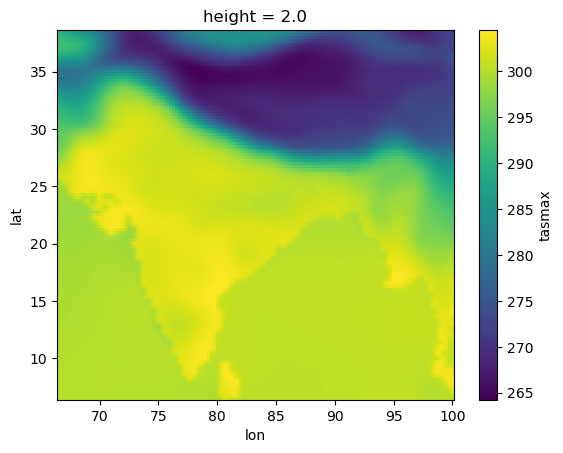

In [126]:
ds_out_Final["tasmax"].mean('time').plot()
